https://heartbeat.fritz.ai/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

https://gist.github.com/risenW

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_pickle('./datasets/clean_df.csv', compression='zip')

In [3]:
# Convert user id and song id to numerical ids
df['user_id'] = df['user'].astype('category').cat.codes
df['song_id'] = df['song'].astype('category').cat.codes

# Create lookup frame so we can get the 'Song - Artist' later
item_lookup = df[['song_id','Song - Artist']].drop_duplicates()
item_lookup['song_id'] = item_lookup['song_id'].astype(str)

In [4]:
# Drop 'user' and 'song' and 'Song - Artist'
df = df.drop(['user','song','Song - Artist'], axis=1)

In [5]:
df = df[['song_id','user_id','count']]

In [6]:
# train-test split 80/20
Xtrain, Xtest = train_test_split(df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (618128, 3)
Shape of test data: (154533, 3)


In [7]:
# Get number of unique entities in songs & users columns
nsong_id = df.song_id.nunique()
nuser_id = df.user_id.nunique()

In [8]:
# Song input network
input_songs = layers.Input(shape=[1])
embed_songs = layers.Embedding(nsong_id + 1, 15)(input_songs)
out_songs = layers.Flatten()(embed_songs)

# User input network
input_users = layers.Input(shape=[1])
embed_users = layers.Embedding(nuser_id + 1, 15)(input_users)
out_users = layers.Flatten()(embed_users)

conc_layer = layers.Concatenate()([out_songs, out_users])
x = layers.Dense(128, activation='relu')(conc_layer)
x_out = x = layers.Dense(1, activation='relu')(x)
model = keras.Model([input_songs, input_users], x_out)

In [9]:
# normal learning rates are around .01
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        55140       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        6273795     input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
# large batch size may work more effectively for sparse dataset
hist = model.fit([Xtrain['song_id'], Xtrain['user_id']], Xtrain['count'], 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest['song_id'], Xtest['user_id']], Xtest['count']))

Epoch 1/5
9659/9659 [==============================] - 389s 40ms/step - loss: 28.8394 - val_loss: 28.4907
Epoch 2/5
9659/9659 [==============================] - 414s 43ms/step - loss: 24.2304 - val_loss: 29.4985
Epoch 3/5
9659/9659 [==============================] - 438s 45ms/step - loss: 20.2321 - val_loss: 31.3561
Epoch 4/5
9659/9659 [==============================] - 421s 44ms/step - loss: 17.3027 - val_loss: 32.5919
Epoch 5/5
9659/9659 [==============================] - 418s 43ms/step - loss: 14.8553 - val_loss: 33.5686


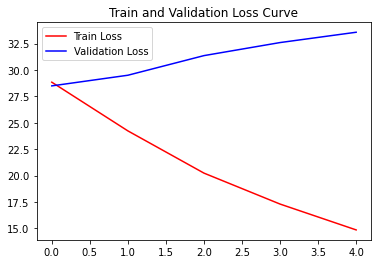

In [14]:
import matplotlib.pyplot as plt
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [15]:
model.save('models/msd_plan01')

INFO:tensorflow:Assets written to: models/msd_plan01/assets
